# TPU를 사용하기 위한 설정

In [ ]:
# BERT는 colab TPU로 학습해야 시간이 덜 걸림

In [ ]:
# #  TPU초기 설정
# import tensorflow as tf
# import os

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)

# strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 기본 구성

In [ ]:
pip install wordcloud

In [ ]:
pip install hanja # 한자 분류 모듈

     |████████████████████████████████| 122kB 6.8MB/s 
     |████████████████████████████████| 266kB 7.9MB/s 
     |████████████████████████████████| 245kB 13.2MB/s 
  Created wheel for hanja: filename=hanja-0.13.3-cp37-none-any.whl size=128426 sha256=3cfcb9e12ac95cfbb19bb3edfec33a3ee7a93c80bc920c58609528159b80de45
  Stored in directory: /root/.cache/pip/wheels/45/fc/c9/b7e7cb5c86935a1a99e2ad07f763728f8f17560e7b815a4b27
  Created wheel for pyyaml: filename=PyYAML-5.1.2-cp37-cp37m-linux_x86_64.whl size=44117 sha256=4ff338c866497d7c3d474808f564a265f9dae0c08de1bdc94e1df8da4b4d3ece
  Stored in directory: /root/.cache/pip/wheels/d9/45/dd/65f0b38450c47cf7e5312883deb97d065e030c5cca0a365030
Successfully built hanja pyyaml
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.

In [ ]:
# !pip install transformers
!pip install transformers==3.2

     |████████████████████████████████| 1.0MB 7.6MB/s 
     |████████████████████████████████| 3.0MB 40.8MB/s 
     |████████████████████████████████| 1.2MB 51.1MB/s 
     |████████████████████████████████| 901kB 45.8MB/s 


In [ ]:
 !nvidia-smi 

Fri Jul  9 03:07:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# pip install kobart-transformers

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import cross_val_score, StratifiedKFold
from tensorflow.keras.models import clone_model

from tqdm import tqdm

import hanja
from hanja import hangul

from transformers import *
# from transformers import BertTokenizer, TFBertModel,PreTrainedTokenizerFast, TFBartModel
# from kobart_transformers import get_kobart_tokenizer, get_kobart_model

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences #tensorflow 전처리 모듈1
from tensorflow.keras.preprocessing.text import Tokenizer #tensorflow 전처리 모듈2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 그래프를 출력창에서 바로 볼 수 있게함
%matplotlib inline 


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/train_data.csv", error_bad_lines=False  )
test = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/test_data.csv",error_bad_lines=False)
submission = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/sample_submission.csv",error_bad_lines=False)
topic_dict = pd.read_csv("/content/drive/MyDrive/DACON/topic_classification/topic_dict.csv",error_bad_lines=False)

# BERT를 이용한 NEWS Topic 분류

### EDA

In [ ]:
import logging
import os
import unicodedata
from shutil import copyfile
 
from transformers import PreTrainedTokenizer
 
 
logger = logging.getLogger(__name__)
 
VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}
 
PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}
 
PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}
 
PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}
 
SPIECE_UNDERLINE = u'▁'
 
 
class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES
 
    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )
 
        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)
 
        self.max_len_single_sentence = self.max_len - 2  # take into account special tokens
        self.max_len_sentences_pair = self.max_len - 3  # take into account special tokens
 
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
 
        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt
 
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)
 
    @property
    def vocab_size(self):
        return len(self.idx2token)
 
    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state
 
    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)
 
    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')
 
        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()
 
        return outputs
 
    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)
 
        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)
 
        return new_pieces
 
    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])
 
    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]
 
    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string
 
    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A RoBERTa sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep
 
    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """
 
        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))
 
        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]
 
    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A BERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]
 
    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return
 
        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])
 
        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)
 
        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1
 
        return out_vocab_model, out_vocab_txt

In [ ]:
def clean_text(texts):
    corpus = []
    texts = texts.replace("日","일본")
    texts = texts.replace("美","미국")
    texts = texts.replace("北","북한")
    texts = texts.replace("英","영국")
    texts = texts.replace("中","중국")
    texts = texts.replace("與","여당")
    texts = texts.replace("靑","청와대")
    texts = texts.replace("野","야당")
    texts = texts.replace("伊","이탈리아")
    texts = texts.replace("韓","한국")
    texts = texts.replace("南","한국")
    texts = texts.replace("獨","독일")
    texts = texts.replace("佛","프랑스")
    texts = texts.replace("檢","검찰")
    texts = texts.replace("銀","은행")
    for i in range(0, len(texts)):
        
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',str(texts[i])) #remove punctuation
        review = re.sub(r'\d+','', str(texts[i]))# remove number
        review = review.lower() #lower case
        review = re.sub(r'\s+', ' ', review) #remove extra space
        review = re.sub(r'<[^>]+>','',review) #remove Html tags
        review = re.sub(r'\s+', ' ', review) #remove spaces
        review = re.sub(r"^\s+", '', review) #remove space from start
        review = re.sub(r'\s+$', '', review) #remove space from the end
        review = re.sub("[一-龥]",'', review) # remove hanja
        corpus.append(review)
    return corpus

In [ ]:
train.title = clean_text(train.title)
test.title = clean_text(test.title)

In [ ]:
train_data_text = list(train['title'])

train_clear_text = []

for i in tqdm(range(len(train_data_text))):
  train_clear_text.append(str(train_data_text[i]).replace('\\n', ''))
train['clear_title'] = train_clear_text


100%|██████████| 45654/45654 [00:00<00:00, 1310888.69it/s]


In [ ]:
train_clear_text = list(train['clear_title'])

train_clear_text2 = []

for text in train_clear_text:
  temp = re.sub('[-=+,#:;//●<>▲\?:^$.☆!★()Ⅰ@*\"※~>`\'…》→←]', ' ', text)
  train_clear_text2.append(temp)
train['clear_title'] = train_clear_text2


In [ ]:
test_data_text = list(test['title'])

test_clear_text = []

for i in tqdm(range(len(test_data_text))):
  test_clear_text.append(test_data_text[i].replace('\\n', ' '))
test['clear_title'] = test_clear_text


100%|██████████| 9131/9131 [00:00<00:00, 1703353.04it/s]


In [ ]:
test_clear_text = list(test['clear_title'])

test_clear_text2 = []

for text in test_clear_text:
  temp = re.sub('[-=+,#:;//●<>▲\?:^$.☆!★()Ⅰ@*\"※~>`\'…》→←]', ' ', text)
  test_clear_text2.append(temp)
test['clear_title'] = test_clear_text2


In [ ]:
train['clear_title']

0               인천 핀란드 항공기 결항 휴가철 여행객 분통
1            실리콘밸리 넘어서겠다 구글 조원 들여 전역 거점화
2         이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3        nyt 클린턴 측근기업 특수관계 조명 공과 사 맞물려종합
4              시진핑 트럼프에 중미 무역협상 조속 타결 희망
                      ...               
45649       kb금융 미국 ib 스티펠과 제휴 선진국 시장 공략
45650     보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토
45651             게시판 키움증권 키움 영웅전 실전투자대회
45652                  답변하는 배기동 국립중앙박물관장
45653       한국인터넷기자상 시상식 내달 일 개최 특별상 김성후
Name: clear_title, Length: 45654, dtype: object

In [ ]:
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1321: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


In [ ]:
model_name = 'monologg/kobert'
SEED_NUM = 977
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)
BATCH_SIZE = 50
NUM_EPOCHS = 20
VALID_SPLIT = 0.2
MAX_LEN = 30
NUM_CLASS = 7
K_SPLIT = 3
# 이상치 데이터로인해 평균이 급격히 올라갈수 있기에 EDA분석을 통해 적절히 정해야함 평균값이던 중간값이던 3사분위 값이던
# EDA를 통해 이상치 데이터가 없으면 최대값이용

In [ ]:


# BERT에 필요한 입력값은 총 3개
# input_ids : 문장을 tokenize해서 index로 변환
# attention_mask : 1은 attention에 영향을 받음, 0은 영향을 받지 않음
# token_type_ids : 0과 1로 문장의 토큰 값을 분리

# special token 역할
# [UNK] : 모르는 단어에 대한 token
# [MASK] : 마스크 token, 사전학습(Pre-training)에서 활용
# [PAD] : 최대 길이를 맞추는 용도
# [SEP] : 문장의 종결을 알림
# [CLS] : 문장의 시작을 알림

def bert_tokenizer(sent, MAX_LEN):

    encoded_dict = tokenizer.encode_plus(
        
        text = sent,
        add_special_tokens = True, # True : 토큰 시작점에 [CLS] 토큰과 토큰의 마지막에 [SEP]토큰을 붙임
        max_length = MAX_LEN, # MAX_LEN 최대 길이에 따라 문장의 길이를 맞추는 작업을 진행 ; MAX_LEN보다 길면 truncate
        pad_to_max_length = True, # True : MAX_LEN의 길이에 미치지 못하는 문장에 padding을 적용 **padding : 길이를 일괄적으로 맞춰주는 것
                                                     # 각 데이터의 길이가 다를경우 모델에 적용할 수 없음 그렇기에 padding진행
                                         
        return_attention_mask = True, # True : BERT에 필요한 입력값 중 attention_mask를 생성
        truncation = True 
        # encoded_plus 과정 중 token_type으로 문장이 1개면 0, 문장이 2개면 0과 1로 구분
    )


    input_id = encoded_dict['input_ids'] # BERT 입력값 중 하나인 input_ids
    attention_mask = encoded_dict['attention_mask'] # attention_mask ; 단순히 padding과 non-padding을 구분
    token_type_id = encoded_dict['token_type_ids'] # 두개의 문장 구분용


    return input_id, attention_mask, token_type_id # 각각의 BERT 입력값들을 encoded_dict를 한 결과를 return

In [ ]:
print(tokenizer.all_special_tokens) # BERT special tokens
print(tokenizer.all_special_ids)  # BERT special tokens의 index

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']
[0, 3, 1, 2, 4]


In [ ]:
def get_kfold_sets(train, k=5):
    kf = KFold(n_splits=k, shuffle=True)
    for train_texts, train_labels in kf.split(train.text.values, train.target.values):
        train_texts, valid_texts, train_labels, valid_labels = train_test_split(train.text.values, train.target.values, test_size=0.2)
        train_input = bert_encode(train_texts, tokenizer, max_len=token_max_len)
        valid_input = bert_encode(valid_texts, tokenizer, max_len=token_max_len)
        
        yield train_input, train_labels, valid_input, valid_labels

def get_train_sets(train):
    train_input = bert_encode(train.text.values, tokenizer, max_len=token_max_len)
    train_labels = train.target.values
    
    return train_input, train_labels


"""

Model cloning is similar to calling a model on new inputs, except that it creates new layers (and thus new weights) instead of sharing the weights of the existing layers.

"""

def cross_val_score(train, k=3, epochs=10, batch_size=16):
    f1_vals = []
    models = []
    i = 0
    for train_input, train_labels, valid_input, valid_labels in get_kfold_sets(train, k=k):

        model = clone_model(model_template)

        model.compile(optimizer=optimizer,
                                loss=loss,
                                metrics=[metric])
        
        train_history = model.fit(
            train_input, train_labels,
            validation_data=(valid_input, valid_labels),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[EarlyStopping(patience=1, monitor='val_mse', mode='min', verbose=True)]
        )
        
        pred = model.predict(valid_input)
        f1_val = f1_score(valid_labels, np.round(pred))
        print(f'f1-val: {f1_val}')
        f1_vals.append(f1_val)
        models.append(model)
        df = pd.DataFrame(train_history.history)
        df['f1-val'] = f1_val
        df.to_csv(f'history_{i}.csv')
        i += 1
    return np.array(f1_vals).mean(), models

k = 5
f1_val, models = cross_val_score(train['clean_text'], k=k)
print(f'f1-mean: {f1_val}')



def get_model(bert_layer, max_len=max_len):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    x = Dense(256, activation='relu')(clf_output)
    out = Dense(n_class, activation='softmax')(x)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model



cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)



p_val = np.zeros((trn[0].shape[0], n_class))
p_tst = np.zeros((tst[0].shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn[0], y), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=2,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)
    
    clf = get_model(bert_layer, max_len=max_len)
    if i == 1:
        print(clf.summary())
        
    clf.fit([x[i_trn] for x in trn], 
            to_categorical(y[i_trn]),
            validation_data=([x[i_val] for x in trn], to_categorical(y[i_val])),
            epochs=10,
            batch_size=8,
            callbacks=[es])
    p_val[i_val, :] = clf.predict([x[i_val] for x in trn])
    p_tst += clf.predict(tst) / n_fold
    
    del clf
    clear_session()
    gc.collect()


print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')

In [ ]:

input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

# bert_tokenizer를 이용하여 encoding진행
for train_sent, train_label in tqdm(zip(train["clear_title"], train["topic_idx"])): 
    try:

        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)
        
    except Exception as e:
        print(e)
        print(train_sent)
        pass


train_news_input_ids = np.array(input_ids, dtype=int)
train_news_attention_masks = np.array(attention_masks, dtype=int)
train_news_type_ids = np.array(token_type_ids, dtype=int)

# 최종 출력값은 numpy로 변환한 후 tuple 형태로 묶어서 저장
train_news_inputs = (train_news_input_ids, train_news_attention_masks, train_news_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) # 정답 tokenizing 리스트


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
45654it [00:07, 6469.86it/s]


In [ ]:
# bert_tokenizer를 통해 실제결과가 나오는지 테스트
INPUT_id = train_news_input_ids[30]
ATTENTION_mask = train_news_attention_masks[30]
TOKEN_TYPE_id = train_news_type_ids[30]

print(INPUT_id)
print(ATTENTION_mask)
print(TOKEN_TYPE_id)
print(tokenizer.decode(INPUT_id))

[   2  517 6605 7096 7565 2643 6150  517  367  398  382 5163 4841 6853
 2268 4519 7979 1133 7438 7328 7053    3    1    1    1    1    1    1
    1    1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[CLS] 셰이크 살만 afc 회장 평양 방문 최휘 국가체육지도위원장[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]


In [ ]:
class TFBertClassifier(tf.keras.Model): # pre_trained된 bert model을 불러와 그 위에 완전연결층 1층을 쌓은 구조
                                                              # class로 모델을 구현하려면 tf.keras.Model을 상속받아야 함
    # TFBertClassifier생성할 때마다 __init__실행                                                          
    def __init__(self, model_name, dir_path, num_class): # model_name : 인자로 받아 활용할 모델 이름, dir_path : 모델이 저장된 위치
                                                                                            # num_class : 원하는 정답의 개수(감성분석인 경우 2; 긍정, 부정)
        # super함수를 통해 부모 클래스(tf.keras.Model)에 있는 __init__함수 호출   
        # tf.keras.Model 클래스를 상속받는 경우 super함수를 통해 부모 클래스에 __init__ 함수의 인자에 모델이름을 전달하면
        # tf.keras.Model을 상속받은 모든 자식은 해당 모델의 이름으로 공통적으로 사용
        super(TFBertClassifier, self).__init__()

         
        self.bert = TFBertModel.from_pretrained(model_name, from_pt=True) # 기존에 pre_trained 한 부분이 로드됨
                                                                                                                                    
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob) # 과적합을 방지하기 위한 layer
        # self.classifier을 통해 topic_idx를 전부 분류
        self.classifier = tf.keras.layers.Dense(num_class,
                                                                    kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                                    name="classifier")  # 완전연결층 1층


    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False): 
        #__init__에서 선언한 내용을 실제 입력을 받고 실행하는 call 메서드임
        # call함수를 호출하면 입력한 inputs을 통해 마지막에 예측값을 출력
        # 영화 리뷰 text를 inputs을 통해 받음
        

        # output 값 : sequence_output, pooled_output, (hidden_states), (attentions)
        # sequence_output : sequence 길이의 출력을 모두 입력으로 받음; 이 벡터의 차원 ' 임베딩 크기 * 최대문장길이'
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids) # bert를 통해 outputs로 결과값을 추출
        pooled_output = outputs[1] # pooled_output
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output) # self.classifier를 통해 완전연결층을 활용하여 최종적으로 self.num_labels 개수에 맞는 예측값을 출력

        return logits

cls_model = TFBertClassifier(model_name=model_name,
                                                dir_path='bert_ckpt', # ???
                                                num_class=NUM_CLASS) # num_class 바꿔야함



All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


### Adam최적화와 손실값, 모델 정확도 정의

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

cls_model.compile(optimizer=optimizer,
                                loss=loss,
                                metrics=[metric])

In [ ]:
# 모델이 어느 시점이 되면 학습평가점수는 높아지는데 검증평가 점수가 낮아지는 overfitting현상이 발생하거나
# 학습도중 특정 상태의 모델에서 하이퍼파라미터를 바꿔서 다시 학습을 진행할 수도 있음
# => tensowflow.keras.callback 모듈의 EarlyStopping, ModelCheckpoint 클래스를 활용하여 해결


# 특정 epoch에서 현재 검증 평가 점수가 이전 검증 평가 점수보다 일정수치 미만으로 낮아지면 학습을 멈추는 역할
# 학습 중 overfitting을 방지한다는 것
es_callback = EarlyStopping(
                                monitor='val_accuracy', # 'val_accuracy'를 통해 검증 평가 점수로 활용한다는 것
                                mode='max',
                                min_delta=0.0001, # 활용한 평가 점수에 따라 현재 점수가 이전 점수에 비해 0.0001 보다 낮아지면 overfitting현상이 발생한다고 생각하고 학습을 멈춤
                                patience=4,
                                baseline=0.4
                                 ) # 검증 평가 점수가 이전 최고 점수보다 높아지지 않는 epoch수가 patience에 입력한 횟수를 넘어가면 학습을 멈춤

# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)



DATA_OUT_PATH = '/content/drive/MyDrive/best_model'
# 오류시 DATA_OUT_PATH = '/content/gdrive/MyDrive/bert_data_out'

checkpoint_path = DATA_OUT_PATH +  '/best_modeling.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

# Epoch마다 모델을 저장하게끔 함(학습중 모델을 저장한다는 것)    
cp_callback = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_accuracy', # save_best_only를 하는 평가기준
    verbose=1, 
    save_best_only=True, # True : 가장 성능이 좋은 모델만 저장한다는 것
    save_weights_only=False # True : 모델 그래프를 전부 저장하는 것이 아닌 모델 가중치만 저장한다는 것
    )


/content/drive/MyDrive/best_model -- Folder already exists 



In [ ]:

# 학습과 eval 시작
history = cls_model.fit(train_news_inputs, train_data_labels, 
                        epochs=NUM_EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_split = VALID_SPLIT, # 학습데이터에서 일정한 비율로 무작위로 나눔
                        callbacks=[es_callback, cp_callback]
                        ) # 검증데이터셋이 있을경우 파라미터로 validation_data = 로 데이터셋을 지정한 다음 validation_split파라미터를 지운다.

Epoch 1/20
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
731/731 [==============================] - 259s 333ms/step - loss: 0.5240 - accuracy: 0.8292 - val_loss: 0.5343 - val_accuracy: 0.8157

Epoch 00001: val_accuracy improved from -inf to 0.81568, saving model to /content/drive/MyDrive/best_model/best_modeling.h5
Epoch 2/20
731/731 [==============================] - 244s 334ms/step - loss: 0.3308 - accuracy: 0.8897 - val_loss: 0.4603 - val_accuracy: 0.8391

Epoch 00002: val_accuracy improved from 0.81568 to 0.83912, saving model to /content/drive/MyDrive/best_model/best_modeling.h5
Epoch 3/20
731/731 [==============================] - 244s 334ms/step - loss: 0.2547 - accuracy: 0.9156 - val_loss: 0.4794 - val_accuracy: 0.8369

Epoch 00003: val_accuracy did not improve from 0.83912
Epoch 4/20
731/731 [==============================] - 244s 333ms/step - loss: 0.1964 - accuracy: 0.9359 - val_loss:

In [ ]:
cls_model.summary()

Model: "tf_bert_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tf_bert_model (TFBertModel)  multiple                  92186880  
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  5383      
Total params: 92,192,263
Trainable params: 92,192,263
Non-trainable params: 0
_________________________________________________________________


## 모델 Test

In [ ]:


input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

# bert_tokenizer를 이용하여 encoding진행
for test_sent in test["clear_title"]: 
    try:

        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        
    except Exception as e:
        print(e)
        print(test_sent)
        pass


test_news_input_ids = np.array(input_ids, dtype=int)
test_news_attention_masks = np.array(attention_masks, dtype=int)
test_news_type_ids = np.array(token_type_ids, dtype=int)

test_news_inputs = (test_news_input_ids, test_news_attention_masks, test_news_type_ids)




/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:

cls_model_1 = TFBertClassifier(model_name=model_name,
                                                dir_path='bert_ckpt', # ???
                                                num_class=NUM_CLASS) # num_class 바꿔야함
cls_model_1.load_weights(os.path.join(DATA_OUT_PATH,'best_modeling.h5')) # 오류시 '/weight.h5'



All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


ValueError: ignored

In [ ]:

predictions = cls_model_1.predict(test_news_inputs)

In [ ]:
submission

,index,topic_idx
0,45654,0
1,45655,0
2,45656,0
3,45657,0
4,45658,0
...,...,...
9126,54780,0
9127,54781,0
9128,54782,0
9129,54783,0


In [ ]:
predictions

array([[ 2.4011965 ,  0.26372206,  2.8268423 , ..., -3.2180736 ,
        -2.4703853 , -2.355632  ],
       [-1.1785142 , -2.1982436 ,  0.35500383, ..., -1.476581  ,
        -0.9007676 , -0.9627352 ],
       [ 0.02171529, -0.05375991,  4.1906133 , ..., -2.3175209 ,
        -2.7942715 ,  1.1940738 ],
       ...,
       [-1.386269  , -1.9737654 ,  4.5388923 , ..., -2.2791831 ,
        -2.6202571 , -0.9814434 ],
       [ 0.5587819 , -1.8787007 ,  3.6454542 , ..., -3.1510034 ,
        -1.9314485 , -0.02879969],
       [ 0.4901229 , -0.0325914 ,  3.011536  , ..., -2.3166714 ,
        -2.1894653 ,  3.8668249 ]], dtype=float32)

In [ ]:
pred = np.argmax(predictions, axis = 1)
submission.topic_idx = pred
submission.sample(3)

#submission.to_csv(path, index = False)

,index,topic_idx
6885,52539,4
7356,53010,1
656,46310,0


In [ ]:
submission

,index,topic_idx
0,45654,2
1,45655,3
2,45656,2
3,45657,0
4,45658,3
...,...,...
9126,54780,3
9127,54781,2
9128,54782,2
9129,54783,2


In [ ]:
submission.to_csv('bert_baseline.csv',index = False)
# submission.to_csv('bert_baseline_1.csv',index = True)

In [ ]:
print(history.history)

{'loss': [0.7074391841888428, 0.4402851462364197, 0.3594503104686737, 0.29631200432777405, 0.24131686985492706, 0.19897915422916412, 0.1633981466293335], 'accuracy': [0.7605071067810059, 0.8519289493560791, 0.8769816160202026, 0.8973797559738159, 0.9168195128440857, 0.9296607375144958, 0.9425840973854065], 'val_loss': [0.6750518679618835, 0.618735134601593, 0.6169738173484802, 0.6421561241149902, 0.6430529356002808, 0.7034903168678284, 0.7511146664619446], 'val_accuracy': [0.75599604845047, 0.7812944650650024, 0.7889606952667236, 0.7833753228187561, 0.8006790280342102, 0.793012797832489, 0.7873179316520691]}


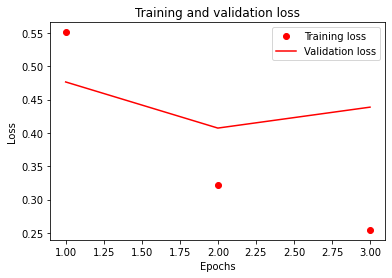

In [ ]:


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

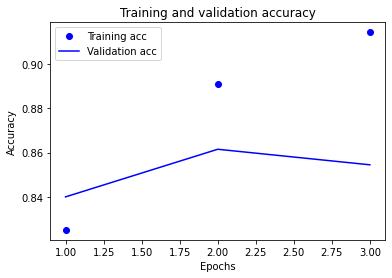

In [ ]:
plt.clf()   # 초기화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
!pip install dacon_submit_api-0.0.4-py3-none-any.whl

Processing ./dacon_submit_api-0.0.4-py3-none-any.whl


In [ ]:
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
'/content/bert_baseline.csv', # 파일경로
'd48ecb3e8cd09e96865d4488c4784b41b44c3f97deba49050f1d400cc324de4a',  # 개인토큰
'235747', # 대회 id
'Healthy Guys',  # 팀이름
'kobert') # 노트

{'isSubmitted': True, 'detail': 'Success'}
